In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import networkx, scprep, magic, torch, pykeen, phate
import rpy2, rpy2.situation
from rpy2.robjects import r, pandas2ri

In [2]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/gpfs/ysm/home/fc489/yaleCollab


Ligand **-***sender|receiver***->** Receptor **-->** Pathway **-->** Target 

* L-R interactions from NichetNet (or anything else really)
* Target gene list from Nichenet too. 
* Pathways from Reactome. Define receptor/target-pathway edge based on ReactomeDB 

We will have to be carefull with the targets added, as in the previous nichenetKG they were the vast majority of nodes.


# Data acquisition

In [3]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

pandas2ri.activate()
%load_ext rpy2.ipython

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Calling `R RHOME`: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/c

## REACTOME

In [4]:
#LIst of pathways of interest (2nd level pathways)
dREACTpaths = pd.read_csv(f"{data_dir}/DBs/ReactomePathwaysRelation.txt", sep="\t", header=None)
dREACTpaths = dREACTpaths.loc[dREACTpaths[0].isin([
                "R-HSA-162582",#Signal transduction
                "R-HSA-5357801",#Programmed cell death
                "R-HSA-73894",#DNA repair
                "R-HSA-8953897",#Cell response to stress
                "R-HSA-1500931",#Cell-cell commns
                "R-HSA-1640170"#Cell cycle
                                                    ]),1]
dREACTpaths.shape

(35,)

In [5]:
dREACTpe = pd.read_csv(f"{data_dir}/DBs/Ensembl2Reactome_PE_All_Levels.txt", sep="\t", header=None)
dREACTpe = dREACTpe.loc[dREACTpe[0].str.startswith("ENSG")|dREACTpe[0].str.startswith("ENSP"),[1,2,3,5]].drop_duplicates()
dREACTpe = dREACTpe.loc[dREACTpe[3].isin(dREACTpaths)]
dREACTpe = dREACTpe.loc[dREACTpe[2].str.match("^\S*[A-Z0-9]+\S*[A-Z0-9]+(\sgene)?(\(\S+\))? \[")][[2,3,5]].dropna().drop_duplicates()
print(dREACTpe[3].nunique())
dREACTpe

35


,2,3,5
1533488,GCLC gene [nucleoplasm],R-HSA-2262752,Cellular responses to stress
1533489,GCLC [cytosol],R-HSA-2262752,Cellular responses to stress
1533535,NFYA [nucleoplasm],R-HSA-2262752,Cellular responses to stress
1533688,CFTR [plasma membrane],R-HSA-9716542,"Signaling by Rho GTPases, Miro GTPases and RHO..."
1533689,CFTR [Golgi-associated vesicle membrane],R-HSA-9716542,"Signaling by Rho GTPases, Miro GTPases and RHO..."
...,...,...,...
2068808,miR-24-2 [cytosol],R-HSA-2262752,Cellular responses to stress
2068823,miR-24-1 [cytosol],R-HSA-2262752,Cellular responses to stress
2070835,ARHGAP11B [cytosol],R-HSA-9716542,"Signaling by Rho GTPases, Miro GTPases and RHO..."
2075559,NPBWR1 [plasma membrane],R-HSA-372790,Signaling by GPCR


## Ligand-Receptors

NicheNet

In [6]:
%%R -o dNNlr
#Directly load RDS object from NicheNet's zenodo repo
dNNlr = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds"))
# dNNgr = readRDS(url("https://zenodo.org/record/3260758/files/gr_network.rds"))
# dNNgrt = readRDS(url("https://zenodo.org/record/3260758/files/tf_target_matrix.rds"))
# dNNlt = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))

In [7]:
print("Ligand-Receptor\n",dNNlr.describe())
# print("TF-Target\n",dNNgr.describe())
# print("TF-Target 2\n",dNNgrt.shape,dNNgrt)
# print("Ligand-Target\n",dNNlt.shape,dNNlt)
dNNlr

Ligand-Receptor
          from     to  source        database
count   12651  12651   12651           12651
unique    688    857      14               5
top       AGT   FPR2  ppi_lr  ppi_prediction
freq      192     79    5956            6304


,from,to,source,database
1,CXCL1,CXCR2,kegg_cytokines,kegg
2,CXCL2,CXCR2,kegg_cytokines,kegg
3,CXCL3,CXCR2,kegg_cytokines,kegg
4,CXCL5,CXCR2,kegg_cytokines,kegg
5,PPBP,CXCR2,kegg_cytokines,kegg
...,...,...,...,...
12647,CXCL6,PIGR,ppi_lr_go,ppi_prediction_go
12648,RLN1,GPR25,ppi_lr_go,ppi_prediction_go
12649,RLN1,RAMP3,ppi_lr_go,ppi_prediction_go
12650,PIK3CB,TNFRSF10A,ppi_bidir_r_go,ppi_prediction_go


On the L-R side, NicheNet seems to have a higher number of interactions
modelled in. We can just use them *as is*.

The tf_target and ligand_target matrix objects don't look to be as useful since the targets they have are actually, if anything, somewaht longer than the targets in the gene regulation database (uncomment .md below to see)
Manual exploration of the tf_target database revealed that all genes with bio meaning I could think of are present in this list.
Afterall,we have 25k genes in here. This is thus, not useful at all.

<!-- Ligand-Receptor
          from     to  source        database
count   12651  12651   12651           12651
unique    688    857      14               5
top       AGT   FPR2  ppi_lr  ppi_prediction
freq      192     79    5956            6304

TF-Target
            from       to              source        database
count   3592299  3592299             3592299         3592299
unique     4486    25103                  20               8
top         YY1   CDKN1A  harmonizome_ENCODE  harmonizome_gr
freq      47472      921             1564116         2953691

TF-Target 2
 (25345, 4486) [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 
Ligand-Target
 (25345, 688) [[0.00035343 0.00040413 0.00037299 ... 0.00028765 0.00036615 0.00032276]
 [0.00016509 0.00015092 0.00015836 ... 0.00014044 0.0001839  0.00017542]
 [0.00057872 0.00045963 0.00038959 ... 0.00053559 0.00051685 0.00040327]
 ...
 [0.00043514 0.00052277 0.00040791 ... 0.00043696 0.00092245 0.00045744]
 [0.00041811 0.00049604 0.00045687 ... 0.00036184 0.00059071 0.00040423]
 [0.00050178 0.00055816 0.00048933 ... 0.00053238 0.00099519 0.00057892]] -->
 

CellChat

In [8]:
dCClr = pd.read_csv(f"{data_dir}/dCellChat_hsapiens.csv.tar.gz",header=None)
dCClr

,0,1,2,3
0,TGFB1,LRinteraction,TGFBR1,TGFb
1,TGFB1,LRinteraction,TGFBR2,TGFb
2,TGFB2,LRinteraction,TGFBR1,TGFb
3,TGFB2,LRinteraction,TGFBR2,TGFb
4,TGFB3,LRinteraction,TGFBR1,TGFb
...,...,...,...,...
1976,VCAM1,LRinteraction,ITGA4,VCAM
1977,VCAM1,LRinteraction,ITGB1,VCAM
1978,VCAM1,LRinteraction,ITGA9,VCAM
1979,VCAM1,LRinteraction,ITGB7,VCAM


Merge NicheNet and CellChat LR databases

In [9]:
dNNlr = pd.DataFrame({
            "head":dNNlr["from"],
            "relation":np.repeat("LR", dNNlr.shape[0]),
            "tail":dNNlr["to"]
        })
dCClr = pd.DataFrame({
            "head":dCClr[0],
            "relation":np.repeat("LR", dCClr.shape[0]),
            "tail":dCClr[2]
        })
dLR = pd.concat([dNNlr, dCClr]).drop_duplicates().reset_index(drop=True)
del dNNlr,dCClr
dLR

,head,relation,tail
0,CXCL1,LR,CXCR2
1,CXCL2,LR,CXCR2
2,CXCL3,LR,CXCR2
3,CXCL5,LR,CXCR2
4,PPBP,LR,CXCR2
...,...,...,...
12927,THY1,LR,ITGB2
12928,THY1,LR,ITGAX
12929,THY1,LR,ITGAV
12930,THY1,LR,ITGB3


## PTMs
Get the PTMs from the cytof dataset. Manually curate them and ensure they match to proper REACTOME PE IDS.

In [10]:
dCyt = pd.read_csv(f"{data_dir}/Omics/dWTfib_cytof.txt",sep="\t").filter(regex = "^\d+|^file_identifier")
dCyt

,89Y_pHH3_S28,111Cd_CD44_v2,113In_CEACAM1_CD66a_v2,114Cd_CK18_v2,115In_Pan-CK_v5,122Te_Barcode,123Te_Barcode,124Te_Barcode,125Te_Barcode,126Te_Barcode,...,172Yb_pS6_S235_236_v2,173Yb_PDPN_v2,174Yb_RFP,175Lu_Vimentin,176Yb_Cyclin_B1_2_v2,191Ir_DNA_1,193Ir_DNA_2,194Pt_Cisplatin,209Bi_CK18,file_identifier
0,0.000000,1990.980957,18.211060,2928.800781,1973.129028,771.304932,14.819576,563.619202,699.982117,25.099878,...,11688.049805,504.713531,29.877979,4299.611816,200.047882,63777.085938,121983.914062,18089.599609,1510.892578,Pro_WTfib_fib
1,0.000000,825.002075,1.621021,8.841931,45.782940,400.186676,53.228016,331.107513,406.801514,51.104706,...,5725.374512,2165.157471,213.488480,1535.135986,132.647461,18011.433594,32582.429688,1185.106079,0.000000,Pro_WTfib_fib
2,0.545875,23.752832,2.710696,75.029808,224.630737,6442.486816,119.965919,6082.173828,6060.972168,700.094177,...,0.000000,515.552185,825.009094,0.000000,37.127651,36602.984375,72815.867188,14817.324219,43.982540,Pro_WTfib_fib
3,1.687439,993.330872,4.313036,18.532772,19.012230,179.756882,25.230639,174.673813,156.020660,21.305735,...,31.062332,453.606934,234.555603,32.569691,10.049050,25414.136719,47861.183594,1220.816040,1.686805,Pro_WTfib_fib
4,0.000000,55.538124,1.648003,29.172148,8.418515,384.167419,13.115532,243.553711,243.389740,24.149267,...,21.605457,161.520538,49.635128,0.000000,0.000000,13607.113281,23980.585938,1471.665405,0.000000,Pro_WTfib_fib
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23944,0.575287,0.000000,29.917067,1177.036377,1878.979126,18780.707031,347.416901,17428.015625,18221.324219,1969.474243,...,5.057156,105.512360,56.930191,0.000000,128.641403,16511.298828,31044.115234,7563.200195,516.480652,Pro_WTfib_epi
23945,8.733110,51.412457,316.347076,2758.709229,1413.775513,17464.484375,319.504669,16184.413086,17701.402344,1702.833252,...,2.509986,6.395815,48.340462,3.997385,336.654144,15596.995117,32046.751953,1247.258301,2554.626221,Pro_WTfib_epi
23946,0.000000,32.676712,47.151875,218.732193,142.701355,4548.200684,99.833855,4417.928711,4601.003906,413.944672,...,0.000000,0.000000,67.100281,0.000000,836.829224,12291.399414,25326.033203,1548.010376,302.388184,Pro_WTfib_epi
23947,2.054595,5.049978,3.555531,236.509842,129.904480,41.158947,3.220307,73.682106,52.007206,9.751757,...,0.000000,0.000000,15.115691,0.000000,27.275177,2755.387939,6044.491699,109.323814,568.037659,Pro_WTfib_epi


In [11]:
dCyt.columns

Index(['89Y_pHH3_S28', '111Cd_CD44_v2', '113In_CEACAM1_CD66a_v2',
       '114Cd_CK18_v2', '115In_Pan-CK_v5', '122Te_Barcode', '123Te_Barcode',
       '124Te_Barcode', '125Te_Barcode', '126Te_Barcode', '127I_IdU',
       '128Te_Barcode', '130Te_Barcode', '140Ce_EQ_Beads',
       '141Pr_pPDK1_S241_v4', '142Nd_cCaspase_3_D175_v3', '143Nd_NaK_ATPase',
       '144Nd_pMEK1_2_S221_v3', '145Nd_CD34', '146Nd_pMKK4_SEK1_S257_v3',
       '147Sm_pBTK_Y511_v4', '148Nd_pSRC_Y418_v5', '149Sm_p4EBP1_T37_T46_v2',
       '150Nd_pRB_S807_S811_v3', '152Sm_pAKT_T308_v7', '153Eu_pCREB_S133_v8',
       '154Sm_pSMAD1_5_9_v5', '155Gd_pAKT_S473_v6', '156Gd_pNF-kB_p65_S529_v4',
       '157Gd_pMKK3_MKK6_S189_207_v3', '158Gd_pP38_MAPK_T180_Y182_v3',
       '159Tb_pMAPKAPK2_T334_v2', '160Gd_pAMPKa_T172_v3', '161Dy_pBAD_S112_v4',
       '162Dy_LRIG1_1_v2', '163Dy_pP90RSK_T359_Hu_v5', '164Dy_Alpha-SMA_2',
       '165Ho_Beta-catenin_Active_1_v4', '166Er_pGSK-3b_S9_v2',
       '167Er_pERK1_2_T202_Y204_v2', '168Er_pSMAD

In [12]:
dPTMs = [
    '89Y_pHH3_S28',
    '141Pr_pPDK1_S241_v4',
    '142Nd_cCaspase_3_D175_v3',
    '144Nd_pMEK1_2_S221_v3',
    '146Nd_pMKK4_SEK1_S257_v3',
    '147Sm_pBTK_Y511_v4', '148Nd_pSRC_Y418_v5', '149Sm_p4EBP1_T37_T46_v2',
    '150Nd_pRB_S807_S811_v3', '152Sm_pAKT_T308_v7', '153Eu_pCREB_S133_v8',
    '154Sm_pSMAD1_5_9_v5', '155Gd_pAKT_S473_v6', '156Gd_pNF-kB_p65_S529_v4',
       '157Gd_pMKK3_MKK6_S189_207_v3', '158Gd_pP38_MAPK_T180_Y182_v3',
       '159Tb_pMAPKAPK2_T334_v2', '160Gd_pAMPKa_T172_v3', '161Dy_pBAD_S112_v4',
    '163Dy_pP90RSK_T359_Hu_v5',
    '166Er_pGSK-3b_S9_v2',
    '167Er_pERK1_2_T202_Y204_v2', '168Er_pSMAD2_3_v4', '169Tm_pSTAT3_Y705',
    '170Er_pMEK1_2_S221_v2',
    '172Yb_pS6_S235_236_v2'
    
]
dCyt = dCyt.filter(dPTMs)
dCyt.columns

Index(['89Y_pHH3_S28', '141Pr_pPDK1_S241_v4', '142Nd_cCaspase_3_D175_v3',
       '144Nd_pMEK1_2_S221_v3', '146Nd_pMKK4_SEK1_S257_v3',
       '147Sm_pBTK_Y511_v4', '148Nd_pSRC_Y418_v5', '149Sm_p4EBP1_T37_T46_v2',
       '150Nd_pRB_S807_S811_v3', '152Sm_pAKT_T308_v7', '153Eu_pCREB_S133_v8',
       '154Sm_pSMAD1_5_9_v5', '155Gd_pAKT_S473_v6', '156Gd_pNF-kB_p65_S529_v4',
       '157Gd_pMKK3_MKK6_S189_207_v3', '158Gd_pP38_MAPK_T180_Y182_v3',
       '159Tb_pMAPKAPK2_T334_v2', '160Gd_pAMPKa_T172_v3', '161Dy_pBAD_S112_v4',
       '163Dy_pP90RSK_T359_Hu_v5', '166Er_pGSK-3b_S9_v2',
       '167Er_pERK1_2_T202_Y204_v2', '168Er_pSMAD2_3_v4', '169Tm_pSTAT3_Y705',
       '170Er_pMEK1_2_S221_v2', '172Yb_pS6_S235_236_v2'],
      dtype='object')

In [13]:
dREACTpe[2]

1533488                     GCLC gene [nucleoplasm]
1533489                              GCLC [cytosol]
1533535                          NFYA [nucleoplasm]
1533688                      CFTR [plasma membrane]
1533689    CFTR [Golgi-associated vesicle membrane]
                             ...                   
2068808                          miR-24-2 [cytosol]
2068823                          miR-24-1 [cytosol]
2070835                         ARHGAP11B [cytosol]
2075559                    NPBWR1 [plasma membrane]
2075577     UGT1A3 [endoplasmic reticulum membrane]
Name: 2, Length: 9385, dtype: object

In [14]:
dREACTpe.loc[dREACTpe[2].str.contains("H3F3A")] #phospho is too restrictive

,2,3,5
1710234,Me2K5-H3F3A [nucleoplasm],R-HSA-1500620,Meiosis
1710235,Me3K5-H3F3A [nucleoplasm],R-HSA-1500620,Meiosis
1710236,H3F3A [nucleoplasm],R-HSA-157118,Signaling by NOTCH
1710237,AcK10-H3F3A [nucleoplasm],R-HSA-157118,Signaling by NOTCH
1710270,H3F3A [nucleoplasm],R-HSA-195721,Signaling by WNT
1710271,Me3K5-H3F3A [nucleoplasm],R-HSA-195721,Signaling by WNT
1710291,H3F3A [nucleoplasm],R-HSA-2262752,Cellular responses to stress
1710292,Me3K-28-H3F3A [nucleoplasm],R-HSA-2262752,Cellular responses to stress
1710293,Me2K-10-H3F3A [nucleoplasm],R-HSA-2262752,Cellular responses to stress
1710346,Me2K5-H3F3A [nucleoplasm],R-HSA-69278,"Cell Cycle, Mitotic"


In [15]:
dREACTpe.loc[dREACTpe[2].str.contains("PDK1")]

,2,3,5
1816163,PDK1 [mitochondrial matrix],R-HSA-9006931,Signaling by Nuclear Receptors


In [16]:
dREACTpe.loc[dREACTpe[2].str.contains("CASP3")]

,2,3,5
1850039,CASP3(176-277) [cytosol],R-HSA-109581,Apoptosis
1850041,CASP3(29-175) [cytosol],R-HSA-109581,Apoptosis
1850043,CASP3(176-277) [nucleoplasm],R-HSA-109581,Apoptosis
1850044,CASP3(29-175) [nucleoplasm],R-HSA-109581,Apoptosis
1850045,CASP3(1-277) [cytosol],R-HSA-109581,Apoptosis
1850090,CASP3(176-277) [cytosol],R-HSA-2028269,Signaling by Hippo
1850091,CASP3(29-175) [cytosol],R-HSA-2028269,Signaling by Hippo
1850113,CASP3(176-277) [cytosol],R-HSA-5218859,Regulated Necrosis
1850114,CASP3(29-175) [cytosol],R-HSA-5218859,Regulated Necrosis
1850129,CASP3(176-277) [cytosol],R-HSA-73887,Death Receptor Signalling


In [17]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S\S*-MAP2K(1|2)\s+")]#MEK1 and 2 are MAP2K1 and 2. No S221

/tmp/ipykernel_14847/2172277998.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S\S*-MAP2K(1|2)\s+")]#MEK1 and 2 are MAP2K1 and 2. No S221


,2,3,5
1694906,"p-S,T-MAP2K2 [cytosol]",R-HSA-5683057,MAPK family signaling cascades
1694908,"p-S222,S226-MAP2K2 [cytosol]",R-HSA-5683057,MAPK family signaling cascades
1694932,"p-S222,S226-MAP2K2 [cytosol]",R-HSA-9006934,Signaling by Receptor Tyrosine Kinases
1872781,"p-S218,S222-MAP2K1 [cytosol]",R-HSA-5683057,MAPK family signaling cascades
1872783,"p-S218,S222,T286,T292-MAP2K1 [cytosol]",R-HSA-5683057,MAPK family signaling cascades
1872825,"p-S218,S222-MAP2K1 [cytosol]",R-HSA-9006934,Signaling by Receptor Tyrosine Kinases


In [18]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S257\S*-MAP2K4")]

,2,3,5
1558821,"p-S257,T261-MAP2K4 [cytosol]",R-HSA-2262752,Cellular responses to stress


In [19]:
dREACTpe.loc[dREACTpe[2].str.contains("BTK")]

,2,3,5
1539418,BTK [cytosol],R-HSA-372790,Signaling by GPCR
1539442,BTK [cytosol],R-HSA-9716542,"Signaling by Rho GTPases, Miro GTPases and RHO..."


In [20]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*Y41\S*-SRC")]#S418 NOT PRESENT

,2,3,5
1952628,MyrG-p-Y419-SRC [plasma membrane],R-HSA-354192,Integrin signaling
1952633,MyrG-p-Y419-SRC [plasma membrane],R-HSA-372790,Signaling by GPCR
1952634,p-Y416-SRC [cytosol],R-HSA-372790,Signaling by GPCR
1952711,MyrG-p-Y419-SRC [plasma membrane],R-HSA-5683057,MAPK family signaling cascades
1952731,p-Y419-SRC [cytosol],R-HSA-69278,"Cell Cycle, Mitotic"
1952766,p-Y419-SRC-1 [plasma membrane],R-HSA-9006925,Intracellular signaling by second messengers
1952767,MyrG-p-Y419-SRC [plasma membrane],R-HSA-9006925,Intracellular signaling by second messengers
1952768,MyrG-p-Y419-SRC [plasma membrane],R-HSA-9006931,Signaling by Nuclear Receptors
1952772,p-Y419-SRC [cytosol],R-HSA-9006934,Signaling by Receptor Tyrosine Kinases
1952776,p-Y419-SRC-1 [plasma membrane],R-HSA-9006934,Signaling by Receptor Tyrosine Kinases


In [21]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*T37,T46\S*-EIF4EBP1")]

,2,3,5
1940322,"p-T37,T46-EIF4EBP1 [cytosol]",R-HSA-165159,MTOR signalling


In [22]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S8\S*-RB1")] #S811 AND S807 ARE SEPARATE TARGETS!

,2,3,5
1746356,p-S811-RB1 [nucleoplasm],R-HSA-69278,"Cell Cycle, Mitotic"
1746361,p-S807-RB1 [nucleoplasm],R-HSA-69278,"Cell Cycle, Mitotic"


In [23]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*T308\S*-AKT1")] 

,2,3,5
1773553,"p-T308,S473-AKT1 [cytosol]",R-HSA-109581,Apoptosis
1773580,"p-T308,S473-AKT1 [cytosol]",R-HSA-157118,Signaling by NOTCH
1773600,"p-T308,S473-AKT1 [plasma membrane]",R-HSA-165159,MTOR signalling
1773612,"p-T308,S473-AKT1 [nucleoplasm]",R-HSA-195721,Signaling by WNT
1773639,"p-T308,S473-AKT1 [cytosol]",R-HSA-2262752,Cellular responses to stress
1773640,"p-T308,S473-AKT1 [plasma membrane]",R-HSA-354192,Integrin signaling
1773712,"p-T308,S473-AKT1 [cytosol]",R-HSA-69278,"Cell Cycle, Mitotic"
1773736,"p-T308,S473-AKT1 [nucleoplasm]",R-HSA-9006925,Intracellular signaling by second messengers
1773738,"p-T308,S473-AKT1 [cytosol]",R-HSA-9006925,Intracellular signaling by second messengers
1773743,p-T308-AKT1 [cytosol],R-HSA-9006925,Intracellular signaling by second messengers


In [24]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S473\S*-AKT1")] 

,2,3,5
1773553,"p-T308,S473-AKT1 [cytosol]",R-HSA-109581,Apoptosis
1773580,"p-T308,S473-AKT1 [cytosol]",R-HSA-157118,Signaling by NOTCH
1773600,"p-T308,S473-AKT1 [plasma membrane]",R-HSA-165159,MTOR signalling
1773612,"p-T308,S473-AKT1 [nucleoplasm]",R-HSA-195721,Signaling by WNT
1773639,"p-T308,S473-AKT1 [cytosol]",R-HSA-2262752,Cellular responses to stress
1773640,"p-T308,S473-AKT1 [plasma membrane]",R-HSA-354192,Integrin signaling
1773712,"p-T308,S473-AKT1 [cytosol]",R-HSA-69278,"Cell Cycle, Mitotic"
1773736,"p-T308,S473-AKT1 [nucleoplasm]",R-HSA-9006925,Intracellular signaling by second messengers
1773738,"p-T308,S473-AKT1 [cytosol]",R-HSA-9006925,Intracellular signaling by second messengers
1773740,p-S473-AKT1 [plasma membrane],R-HSA-9006925,Intracellular signaling by second messengers


In [25]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S133\S*-CREB1")]

,2,3,5
1671441,p-S133-CREB1 [nucleoplasm],R-HSA-157118,Signaling by NOTCH
1671504,p-S133-CREB1 [nucleoplasm],R-HSA-2262752,Cellular responses to stress
1671507,p-S133-CREB1 [nucleoplasm],R-HSA-372790,Signaling by GPCR
1671569,p-S133-CREB1 [nucleoplasm],R-HSA-9006925,Intracellular signaling by second messengers
1671572,p-S133-CREB1 [nucleoplasm],R-HSA-9006931,Signaling by Nuclear Receptors
1671575,p-S133-CREB1 [nucleoplasm],R-HSA-9006934,Signaling by Receptor Tyrosine Kinases


In [26]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S+-SMAD(1|5|9)")]

/tmp/ipykernel_14847/1415456860.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  dREACTpe.loc[dREACTpe[2].str.contains("p-\S+-SMAD(1|5|9)")]


,2,3,5
1654581,"p-S463,S465-SMAD5 [cytosol]",R-HSA-9006936,Signaling by TGFB family members
1654582,"p-S463,S465-SMAD5 [nucleoplasm]",R-HSA-9006936,Signaling by TGFB family members
1675873,"p-S465,S467-SMAD9 [cytosol]",R-HSA-9006936,Signaling by TGFB family members
1675874,"p-S465,S467-SMAD9 [nucleoplasm]",R-HSA-9006936,Signaling by TGFB family members
1884465,"p-S463,S465-SMAD1 [nucleoplasm]",R-HSA-9006936,Signaling by TGFB family members
1884466,"p-S463,S465-SMAD1 [cytosol]",R-HSA-9006936,Signaling by TGFB family members


In [27]:
dREACTpe.loc[dREACTpe[2].str.contains("RELA")] #Rela is the gene for NFKB p65

,2,3,5
1896422,RELA [nucleoplasm],R-HSA-2262752,Cellular responses to stress
1896474,RELA [nucleoplasm],R-HSA-73887,Death Receptor Signalling
1896475,RELA [cytosol],R-HSA-73887,Death Receptor Signalling


In [28]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S\S*-MAP2K(3|6)")]

/tmp/ipykernel_14847/3307753430.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S\S*-MAP2K(3|6)")]


,2,3,5
1546976,"p-S189,T193-MAP2K3 [nucleoplasm]",R-HSA-2262752,Cellular responses to stress
1546977,"p-S189,T193-MAP2K3 [cytosol]",R-HSA-2262752,Cellular responses to stress
1638142,"p-S207,T211-MAP2K6 [cytosol]",R-HSA-2262752,Cellular responses to stress
1638143,"p-S207,T211-MAP2K6 [nucleoplasm]",R-HSA-2262752,Cellular responses to stress


In [29]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*T180,Y182\S*-MAPK(14|11|13|12)")]

/tmp/ipykernel_14847/3006673054.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  dREACTpe.loc[dREACTpe[2].str.contains("p-\S*T180,Y182\S*-MAPK(14|11|13|12)")]


,2,3,5
1648586,"p-T180,Y182-MAPK14 [nucleoplasm]",R-HSA-2262752,Cellular responses to stress
1648644,"p-T180,Y182-MAPK14 [nucleoplasm]",R-HSA-9006934,Signaling by Receptor Tyrosine Kinases
1648645,"p-T180,Y182-MAPK14 [cytosol]",R-HSA-9006934,Signaling by Receptor Tyrosine Kinases
1648658,"p-T180,Y182-MAPK14 [cytosol]",R-HSA-9716542,"Signaling by Rho GTPases, Miro GTPases and RHO..."
1933529,"p-T180,Y182-MAPK11 [nucleoplasm]",R-HSA-2262752,Cellular responses to stress
1933573,"p-T180,Y182-MAPK11 [nucleoplasm]",R-HSA-9006934,Signaling by Receptor Tyrosine Kinases
1933576,"p-T180,Y182-MAPK11 [cytosol]",R-HSA-9006934,Signaling by Receptor Tyrosine Kinases
1933583,"p-T180,Y182-MAPK11 [cytosol]",R-HSA-9716542,"Signaling by Rho GTPases, Miro GTPases and RHO..."


In [30]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*T334\S*-MAPKAPK2")]

,2,3,5
1841759,"p-T222,S272,T334-MAPKAPK2 [nucleoplasm]",R-HSA-2262752,Cellular responses to stress
1841794,"p-S272,T222,T334-MAPKAPK2 [cytosol]",R-HSA-9006934,Signaling by Receptor Tyrosine Kinases


In [31]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*T1\S*PRKAA1")] #PRKAA1 is AMPKa subunit alpha

,2,3,5
1709810,p-T183-PRKAA1 [cytosol],R-HSA-165159,MTOR signalling


In [32]:
dREACTpe.loc[dREACTpe[2].str.contains("BAD")] #S112 not present

,2,3,5
1533847,BAD [mitochondrial outer membrane],R-HSA-109581,Apoptosis
1533848,BAD [cytosol],R-HSA-109581,Apoptosis
1533850,p-S99-BAD [cytosol],R-HSA-109581,Apoptosis
1533895,p-S128-BAD [cytosol],R-HSA-73887,Death Receptor Signalling
1533896,BAD [cytosol],R-HSA-73887,Death Receptor Signalling
1533897,BAD [cytosol],R-HSA-9006925,Intracellular signaling by second messengers
1533898,p-S99-BAD [cytosol],R-HSA-9006925,Intracellular signaling by second messengers


In [33]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*T359\S*-RPS6KA1")]#Rps6ka1 is P90RSK

,2,3,5
1669888,"p-4S,T359,T573-RPS6KA1 [nucleoplasm]",R-HSA-2262752,Cellular responses to stress
1669897,"p-4S,T359,T573-RPS6KA1 [nucleoplasm]",R-HSA-372790,Signaling by GPCR
1669943,"p-4S,T359,T573-RPS6KA1 [nucleoplasm]",R-HSA-9006934,Signaling by Receptor Tyrosine Kinases


In [34]:
dREACTpe.loc[dREACTpe[2].str.contains("GSK3B")] #Limit to S9 too stringent

,2,3,5
1581008,GSK3B [cytosol],R-HSA-195721,Signaling by WNT
1581019,GSK3B [cytosol],R-HSA-2262752,Cellular responses to stress
1581020,GSK3B [nucleoplasm],R-HSA-2262752,Cellular responses to stress
1581037,GSK3B [cytosol],R-HSA-5358351,Signaling by Hedgehog
1581057,GSK3B [nucleoplasm],R-HSA-69278,"Cell Cycle, Mitotic"
1581066,GSK3B [cytosol],R-HSA-9006925,Intracellular signaling by second messengers
1581067,p-S9-GSK3B [cytosol],R-HSA-9006925,Intracellular signaling by second messengers


In [35]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S+-MAPK(3|1)\s+")]#MAPK3 is ERK1. MAPK1 is ERK2, which doesnt have neither T202 nor Y204

/tmp/ipykernel_14847/1944035550.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  dREACTpe.loc[dREACTpe[2].str.contains("p-\S+-MAPK(3|1)\s+")]#MAPK3 is ERK1. MAPK1 is ERK2, which doesnt have neither T202 nor Y204


,2,3,5
1598638,"p-T185,Y187-MAPK1 [cytosol]",R-HSA-109581,Apoptosis
1598785,"p-T185,Y187-MAPK1 [nucleoplasm]",R-HSA-2262752,Cellular responses to stress
1598787,"p-T185,Y187-MAPK1 [cytosol]",R-HSA-2262752,Cellular responses to stress
1598798,"p-T185,Y187-MAPK1 [nucleoplasm]",R-HSA-372790,Signaling by GPCR
1598799,"p-T185,Y187-MAPK1 [cytosol]",R-HSA-372790,Signaling by GPCR
1598871,"p-T185,Y187-MAPK1 [nucleoplasm]",R-HSA-5683057,MAPK family signaling cascades
1598872,"p-T185,Y187-MAPK1 [cytosol]",R-HSA-5683057,MAPK family signaling cascades
1598875,p-T185-MAPK1 [cytosol],R-HSA-5683057,MAPK family signaling cascades
1598909,"p-T185,Y187-MAPK1 [cytosol]",R-HSA-69278,"Cell Cycle, Mitotic"
1598933,"p-T185,Y187-MAPK1 [cytosol]",R-HSA-9006925,Intracellular signaling by second messengers


In [36]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S+-SMAD(2|3)")]

/tmp/ipykernel_14847/1283311083.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  dREACTpe.loc[dREACTpe[2].str.contains("p-\S+-SMAD(2|3)")]


,2,3,5
1862391,"p-S423,S425-SMAD3 [cytosol]",R-HSA-157118,Signaling by NOTCH
1862562,"p-S423,S425-SMAD3 [nucleoplasm]",R-HSA-9006936,Signaling by TGFB family members
1862564,"p-S423,S425-SMAD3 [cytosol]",R-HSA-9006936,Signaling by TGFB family members
1862566,"p-T179,S423,S425-SMAD3 [nucleoplasm]",R-HSA-9006936,Signaling by TGFB family members
1862567,"Ub,p-T179,S423,S425-SMAD3 [nucleoplasm]",R-HSA-9006936,Signaling by TGFB family members
1862568,"2xADPRib-p-S423,S425-SMAD3 [nucleoplasm]",R-HSA-9006936,Signaling by TGFB family members
1862570,p-S208-SMAD3 [cytosol],R-HSA-9006936,Signaling by TGFB family members
1905060,"p-S465,S467-SMAD2 [nucleoplasm]",R-HSA-9006936,Signaling by TGFB family members
1905062,"p-S465,S467-SMAD2 [cytosol]",R-HSA-9006936,Signaling by TGFB family members
1905064,"p-T220,S465,S467-SMAD2 [nucleoplasm]",R-HSA-9006936,Signaling by TGFB family members


In [37]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S*Y705\S*-STAT3")]

,2,3,5
1870463,p-Y705-STAT3 [nucleoplasm],R-HSA-109581,Apoptosis
1870531,p-Y705-STAT3 [nucleoplasm],R-HSA-2262752,Cellular responses to stress
1870532,p-Y705-STAT3 [cytosol],R-HSA-2262752,Cellular responses to stress
1870536,p-Y705-STAT3 [nucleoplasm],R-HSA-2586552,Signaling by Leptin
1870537,p-Y705-STAT3 [cytosol],R-HSA-2586552,Signaling by Leptin
1870621,p-Y705-STAT3 [nucleoplasm],R-HSA-9006927,Signaling by Non-Receptor Tyrosine Kinases
1870623,p-Y705-STAT3 [cytosol],R-HSA-9006927,Signaling by Non-Receptor Tyrosine Kinases
1870626,p-Y705-STAT3 [nucleoplasm],R-HSA-9006934,Signaling by Receptor Tyrosine Kinases
1870628,p-Y705-STAT3 [cytosol],R-HSA-9006934,Signaling by Receptor Tyrosine Kinases
1870632,"p-Y705,S727-STAT3 [cytosol]",R-HSA-9006934,Signaling by Receptor Tyrosine Kinases


In [38]:
dREACTpe.loc[dREACTpe[2].str.contains("p-\S+-RPS6\s+")]

,2,3,5
1730459,p-5S-RPS6 [cytosol],R-HSA-165159,MTOR signalling


In [39]:
#Dict of regex used to get the PTMs
PTMdict = {
    '89Y_pHH3_S28':"H3F3A",
    '141Pr_pPDK1_S241_v4':"PDK1",
    '142Nd_cCaspase_3_D175_v3':"CASP3",
    '144Nd_pMEK1_2_S221_v3':"p-\S*S\S*-MAP2K(1|2)\s+",
    '146Nd_pMKK4_SEK1_S257_v3':"p-\S*S257\S*-MAP2K4",
    '147Sm_pBTK_Y511_v4':"BTK",
    '148Nd_pSRC_Y418_v5':"p-\S*Y41\S*-SRC",
    '149Sm_p4EBP1_T37_T46_v2':"p-\S*T37,T46\S*-EIF4EBP1",
    '150Nd_pRB_S807_S811_v3':"p-\S*S8\S*-RB1",
    '152Sm_pAKT_T308_v7':"p-\S*T308\S*-AKT1",
    '153Eu_pCREB_S133_v8':"p-\S*S473\S*-AKT1",
    '154Sm_pSMAD1_5_9_v5':"p-\S*S133\S*-CREB1",
    '155Gd_pAKT_S473_v6':"p-\S+-SMAD(1|5|9)",
    '156Gd_pNF-kB_p65_S529_v4':"RELA",
    '157Gd_pMKK3_MKK6_S189_207_v3':"p-\S*S\S*-MAP2K(3|6)", 
    '158Gd_pP38_MAPK_T180_Y182_v3':"p-\S*T180,Y182\S*-MAPK(14|11|13|12)",
    '159Tb_pMAPKAPK2_T334_v2':"p-\S*T334\S*-MAPKAPK2", 
    '160Gd_pAMPKa_T172_v3':"p-\S*T1\S*PRKAA1", 
    '161Dy_pBAD_S112_v4':"BAD",
    '163Dy_pP90RSK_T359_Hu_v5':"p-\S*T359\S*-RPS6KA1",
    '166Er_pGSK-3b_S9_v2':"GSK3B",
    '167Er_pERK1_2_T202_Y204_v2':"p-\S+-MAPK(3|1)\s+", 
    '168Er_pSMAD2_3_v4':"p-\S+-SMAD(2|3)", 
    '169Tm_pSTAT3_Y705':"p-\S*Y705\S*-STAT3",
    '170Er_pMEK1_2_S221_v2':"p-\S*S\S*-MAP2K(1|2)\s+",
    '172Yb_pS6_S235_236_v2':"p-\S+-RPS6\s+"
}

# KG assembly

* Set of triples from L-R database:
    * Replicate triples for as many pathways are found to contain both Ligand and Receptor entities
* Set of triples from R-PTMs:
    * If Receptor and PTM in the same pathway, define triple with pathway edge annotation.
    * Get pathway PTMs by using the contains method snippet above and subsetting to unique entries in 5.
    * Notes:
        * For ab with multiple targets, have one entity per target
        * In the KG, define PTM entity names as GENE names
        * Before projecting:
            * Change column names in cytof dataset to gene names
            * Duplicate columns that have multiple targets

## L-R pathway edges

In [40]:
#Make df with only gene names. Group by pathway. IF both L and R in same group, we have a hit!
mdPathPE = dREACTpe.copy(deep=True)
mdPathPE[2] = mdPathPE[2].str.extract("^([A-Z0-9]+-*[A-Z0-9]+)")[0]
mdPathPE = mdPathPE.dropna().drop_duplicates()
mdPathPE = mdPathPE.groupby(by=[5])
mdPathPE.describe()

2                       \
                                                   count unique      top freq   
5                                                                               
Apoptosis                                            173    173      BAD    1   
Base Excision Repair                                  75     75     LIG3    1   
Cell Cycle Checkpoints                               259    259   MAD1L1    1   
Cell Cycle, Mitotic                                  518    518   MAD1L1    1   
Cell junction organization                            91     91   CLDN11    1   
Cellular responses to stress                         757    757     GCLC    1   
Chromosome Maintenance                               119    119   POLR2J    1   
DNA Damage Bypass                                     51     51    REV3L    1   
DNA Damage Reversal                                    8      8   ALKBH5    1   
DNA Double-Strand Break Repair                       153    153    RAD52    1   
Death Receptor Signalling                            148    148      BAD    1   
Fanconi Anemia Pathway                                38     38    ERCC1    1   
Integrin signaling                                    26     26   ITGA2B    1   
Intracellular signaling by second messengers         282    282      BAD    1   
MAPK family signaling cascades                       290    290   ITGA2B    1   
MTOR signalling                                       39     39    RRAGD    1   
Meiosis                                               85     85    BRCA1    1   
Mismatch Repair                                       15     15    POLD1    1   
Nephrin family interactions                           23     23      FYN    1   
Nucleotide Excision Repair                           120    120   POLR2J    1   
Regulated Necrosis                                    57     57    CFLAR    1   
Response to metal ions                                14     14     SNCB    1   
Signal regulatory protein family interactions         16     16    SKAP2    1   
Signaling by Erythropoietin                           22     22   PIK3CB    1   
Signaling by GPCR                                    693    693    WNT16    1   
Signaling by Hedgehog                                157    157  PRKAR2B    1   
Signaling by Hippo                                    20     20     DVL2    1   
Signaling by Leptin                                   11     11     JAK2    1   
Signaling by NOTCH                                   216    216   PLXND1    1   
Signaling by Non-Receptor Tyrosine Kinases            49     49    BCAR1    1   
Signaling by Nuclear Receptors                       258    258  CYP26B1    1   
Signaling by Receptor Tyrosine Kinases               509    509   POLR2J    1   
Signaling by Rho GTPases, Miro GTPases and RHOBTB3   679    679     CFTR    1   
Signaling by TGFB family members                     119    119    WWTR1    1   
Signaling by WNT                                     298    298      N4G    1   

                                                       3         \
                                                   count unique   
5                                                                 
Apoptosis                                            173      1   
Base Excision Repair                                  75      1   
Cell Cycle Checkpoints                               259      1   
Cell Cycle, Mitotic                                  518      1   
Cell junction organization                            91      1   
Cellular responses to stress                         757      1   
Chromosome Maintenance                               119      1   
DNA Damage Bypass                                     51      1   
DNA Damage Reversal                                    8      1   
DNA Double-Strand Break Repair                       153      1   
Death Receptor Signalling                            148      1   
Fanconi Anemia Pathway                

In [41]:
for name, group in mdPathPE:
    print(name)
    print(group)

Apoptosis
              2             3          5
1533847     BAD  R-HSA-109581  Apoptosis
1534257   CFLAR  R-HSA-109581  Apoptosis
1534260    FLIP  R-HSA-109581  Apoptosis
1537818   PSMB1  R-HSA-109581  Apoptosis
1542662   PSMC4  R-HSA-109581  Apoptosis
...         ...           ...        ...
1992777   UBA52  R-HSA-109581  Apoptosis
1994510  PSMB11  R-HSA-109581  Apoptosis
2021387   PSMB9  R-HSA-109581  Apoptosis
2033298  DYNLL2  R-HSA-109581  Apoptosis
2047968   PSMB3  R-HSA-109581  Apoptosis

[173 rows x 3 columns]
Base Excision Repair
                 2            3                     5
1535510       LIG3  R-HSA-73884  Base Excision Repair
1547379       RFC1  R-HSA-73884  Base Excision Repair
1548482       PNKP  R-HSA-73884  Base Excision Repair
1551191       RFC2  R-HSA-73884  Base Excision Repair
1556530      POLD1  R-HSA-73884  Base Excision Repair
...            ...          ...                   ...
2041680  HIST1H2BO  R-HSA-73884  Base Excision Repair
2046657  HIST1H2BH  R

In [42]:
# %%time
# dLRpath = pd.DataFrame(columns=["head","relation","tail"])
# for i in dLR.iterrows():
#     for name, group in mdPathPE:
#         if any(group[2].str.contains(i[1]["head"])):
#             if any(group[2].str.contains(i[1]["tail"])):
#                 row = pd.Series({"head":i[1]["head"], "relation":name, "tail":i[1]["tail"]})
#                 dLRpath = pd.concat([dLRpath, row.to_frame().T])
# dLRpath = dLRpath.reset_index(drop=True)
# dLRpath.to_csv(f"{data_dir}/dLRpath.csv.tar.gz", index=False)

CPU times: user 3min 29s, sys: 123 ms, total: 3min 29s
Wall time: 3min 29s


In [43]:
dLRpath = pd.read_csv(f"{data_dir}/dLRpath.csv.tar.gz")

In [44]:
dLRpath

,head,relation,tail
0,CXCL1,Signaling by GPCR,CXCR2
1,CXCL2,Signaling by GPCR,CXCR2
2,CXCL3,Signaling by GPCR,CXCR2
3,CXCL5,Signaling by GPCR,CXCR2
4,PPBP,Signaling by GPCR,CXCR2
...,...,...,...
9613,LAMA3,Cell junction organization,ITGB4
9614,LAMB3,Cell junction organization,ITGB4
9615,VWF,MAPK family signaling cascades,GP
9616,CDH1,Cell junction organization,ITGB1


## R-PTM pathway edges

In [45]:
mdPathPE = dREACTpe.copy(deep=True)
#No longer filter to just genes
mdPathPE = mdPathPE.dropna().drop_duplicates()
mdPathPE = mdPathPE.groupby(by=[5])
mdPathPE.describe()

2         \
                                                   count unique   
5                                                                 
Apoptosis                                            321    321   
Base Excision Repair                                  76     76   
Cell Cycle Checkpoints                               328    328   
Cell Cycle, Mitotic                                  873    873   
Cell junction organization                           120    120   
Cellular responses to stress                        1130   1130   
Chromosome Maintenance                               121    121   
DNA Damage Bypass                                     66     66   
DNA Damage Reversal                                    9      9   
DNA Double-Strand Break Repair                       227    227   
Death Receptor Signalling                            245    245   
Fanconi Anemia Pathway                                55     55   
Integrin signaling                                    36     36   
Intracellular signaling by second messengers         415    415   
MAPK family signaling cascades                       504    504   
MTOR signalling                                       55     55   
Meiosis                                               92     92   
Mismatch Repair                                       15     15   
Nephrin family interactions                           24     24   
Nucleotide Excision Repair                           152    152   
Regulated Necrosis                                   115    115   
Response to metal ions                                16     16   
Signal regulatory protein family interactions         17     17   
Signaling by Erythropoietin                           33     33   
Signaling by GPCR                                    810    810   
Signaling by Hedgehog                                289    289   
Signaling by Hippo                                    38     38   
Signaling by Leptin                                   22     22   
Signaling by NOTCH                                   337    337   
Signaling by Non-Receptor Tyrosine Kinases            93     93   
Signaling by Nuclear Receptors                       354    354   
Signaling by Receptor Tyrosine Kinases               950    950   
Signaling by Rho GTPases, Miro GTPases and RHOBTB3   785    785   
Signaling by TGFB family members                     199    199   
Signaling by WNT                                     463    463   

                                                                                                    \
                                                                                               top   
5                                                                                                    
Apoptosis                                                       BAD [mitochondrial outer membrane]   
Base Excision Repair                                                            LIG3 [nucleoplasm]   
Cell Cycle Checkpoints                                                            MAD1L1 [cytosol]   
Cell Cycle, Mitotic                                                               MAD1L1 [cytosol]   
Cell junction organization                                                  CLDN11 [cell junction]   
Cellular responses to stress                                               GCLC gene [nucleoplasm]   
Chromosome Maintenance                                                        POLR2J [nucleoplasm]   
DNA Damage Bypass                                                              REV3L [nucleoplasm]   
DNA Damage Reversal                                                           ALKBH5 [nucleoplasm]   
DNA Double-Strand Break Repair                                          p-Y104-RAD52 [nucleoplasm]   
Death Receptor Signalling                                                     p-S128-BAD [cytosol]   
Fanconi Anemia Pathway                                                         E

In [46]:
PTMdict.values()

dict_values(['H3F3A', 'PDK1', 'CASP3', 'p-\\S*S\\S*-MAP2K(1|2)\\s+', 'p-\\S*S257\\S*-MAP2K4', 'BTK', 'p-\\S*Y41\\S*-SRC', 'p-\\S*T37,T46\\S*-EIF4EBP1', 'p-\\S*S8\\S*-RB1', 'p-\\S*T308\\S*-AKT1', 'p-\\S*S473\\S*-AKT1', 'p-\\S*S133\\S*-CREB1', 'p-\\S+-SMAD(1|5|9)', 'RELA', 'p-\\S*S\\S*-MAP2K(3|6)', 'p-\\S*T180,Y182\\S*-MAPK(14|11|13|12)', 'p-\\S*T334\\S*-MAPKAPK2', 'p-\\S*T1\\S*PRKAA1', 'BAD', 'p-\\S*T359\\S*-RPS6KA1', 'GSK3B', 'p-\\S+-MAPK(3|1)\\s+', 'p-\\S+-SMAD(2|3)', 'p-\\S*Y705\\S*-STAT3', 'p-\\S*S\\S*-MAP2K(1|2)\\s+', 'p-\\S+-RPS6\\s+'])

In [47]:
dLR["tail"].unique()

array(['CXCR2', 'CXCR1', 'CXCR3', 'CXCR4', 'CXCR5', 'CXCR6', 'XCR1',
       'CX3CR1', 'CCR6', 'CCR9', 'CCR4', 'CCR7', 'CCR2', 'CCR5', 'CCR3',
       'CCR1', 'CCR10', 'IL6ST', 'IL6R', 'IL11RA', 'LIFR', 'OSMR',
       'CNTFR', 'CSF3R', 'LEPR', 'IL13RA1', 'IL4R', 'IL12RB2', 'IL12RB1',
       'IL23R', 'CSF2RB', 'CSF2RA', 'IL3RA', 'IL5RA', 'IL2RG', 'IL2RB',
       'IL2RA', 'IL7R', 'IL9R', 'IL15RA', 'IL21R', 'CRLF2', 'EPOR', 'GHR',
       'PRLR', 'MPL', 'PDGFRA', 'PDGFRB', 'FLT1', 'KDR', 'FLT4', 'MET',
       'EGFR', 'CSF1R', 'KIT', 'FLT3', 'IFNAR2', 'IFNAR1', 'IFNGR2',
       'IFNGR1', 'IL10RB', 'IL10RA', 'IL20RA', 'IL22RA1', 'IL22RA2',
       'IFNLR1', 'TNFRSF10A', 'TNFRSF10B', 'TNFRSF10C', 'TNFRSF10D',
       'TNFRSF11B', 'TNFRSF11A', 'TNFRSF12A', 'TNFRSF1B', 'TNFRSF1A',
       'LTBR', 'TNFRSF14', 'TNFRSF6B', 'FAS', 'CD40', 'CD27', 'TNFRSF8',
       'TNFRSF9', 'TNFRSF4', 'TNFRSF18', 'TNFRSF17', 'TNFRSF13B',
       'TNFRSF13C', 'EDAR', 'EDA2R', 'TGFBR1', 'TGFBR2', 'ACVR1',
       'ACVR2A',

In [48]:
# %%time
# dRPTMpath = pd.DataFrame(columns=["head","relation","tail"])
# for p in PTMdict.values():
#     for r in dLR["tail"].unique():
#         for name, group in mdPathPE:
#             if any(group[2].str.contains(r)):
#                 if any(group[2].str.contains(p)):
#                     row = pd.Series({"head":r, "relation":name, "tail":p})
#                     dRPTMpath = pd.concat([dRPTMpath, row.to_frame().T])
# dRPTMpath = dRPTMpath.dropna().drop_duplicates().reset_index(drop=True)
# dRPTMpath.to_csv(f"{data_dir}/dLPTMpath.csv.tar.gz", index=False)

<timed exec>:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


CPU times: user 6min 28s, sys: 263 ms, total: 6min 29s
Wall time: 6min 29s


In [51]:
dRPTMpath = pd.read_csv(f"{data_dir}/dLPTMpath.csv.tar.gz")

In [52]:
dRPTMpath

,head,relation,tail
0,FLT4,Signaling by NOTCH,H3F3A
1,EGFR,Signaling by NOTCH,H3F3A
2,EGFR,Signaling by Nuclear Receptors,H3F3A
3,FAS,Signaling by Nuclear Receptors,H3F3A
4,CD2,Signaling by NOTCH,H3F3A
...,...,...,...
3268,VEGFR2,Signaling by Receptor Tyrosine Kinases,p-\S*Y705\S*-STAT3
3269,GP,Apoptosis,p-\S*Y705\S*-STAT3
3270,GP,Cellular responses to stress,p-\S*Y705\S*-STAT3
3271,GP,Signaling by Non-Receptor Tyrosine Kinases,p-\S*Y705\S*-STAT3


## Assembled KG

In [53]:
dKGlrp = pd.concat([dLR, dLRpath, dRPTMpath]).drop_duplicates().reset_index(drop=True)
dKGlrp

,head,relation,tail
0,CXCL1,LR,CXCR2
1,CXCL2,LR,CXCR2
2,CXCL3,LR,CXCR2
3,CXCL5,LR,CXCR2
4,PPBP,LR,CXCR2
...,...,...,...
25818,VEGFR2,Signaling by Receptor Tyrosine Kinases,p-\S*Y705\S*-STAT3
25819,GP,Apoptosis,p-\S*Y705\S*-STAT3
25820,GP,Cellular responses to stress,p-\S*Y705\S*-STAT3
25821,GP,Signaling by Non-Receptor Tyrosine Kinases,p-\S*Y705\S*-STAT3


In [54]:
dKGlrp.to_csv(f"{data_dir}/dKGlrp.csv.tar.gz", index=False, header=False)

In [55]:
dKGlrp = pd.read_csv(f"{data_dir}/dKGlrp.csv.tar.gz", header=None)
dKGlrp

,0,1,2
0,CXCL1,LR,CXCR2
1,CXCL2,LR,CXCR2
2,CXCL3,LR,CXCR2
3,CXCL5,LR,CXCR2
4,PPBP,LR,CXCR2
...,...,...,...
25818,VEGFR2,Signaling by Receptor Tyrosine Kinases,p-\S*Y705\S*-STAT3
25819,GP,Apoptosis,p-\S*Y705\S*-STAT3
25820,GP,Cellular responses to stress,p-\S*Y705\S*-STAT3
25821,GP,Signaling by Non-Receptor Tyrosine Kinases,p-\S*Y705\S*-STAT3


### As a multigraph in NetworkX

In [56]:
G = networkx.from_pandas_edgelist(
    dKGlrp,
    source=0,target=2,
    edge_key=1,
    create_using=networkx.MultiGraph())
G

In [57]:
print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
        networkx.number_of_isolates(G))
print("The graph is connected:",
        networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

/tmp/ipykernel_14847/2264486704.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")


MultiGraph with 1630 nodes and 25823 edges, with a density of 0.019450376044620698
We have this many isolates:  0
The graph is connected: False

We have 20 connected subgraphs
Component 1: MultiGraph with 1585 nodes and 25793 edges, with a density of 0.020546952171557848
Component 2: MultiGraph with 2 nodes and 1 edges, with a density of 1.0
Component 3: MultiGraph with 2 nodes and 1 edges, with a density of 1.0
Component 4: MultiGraph with 2 nodes and 1 edges, with a density of 1.0
Component 5: MultiGraph with 1 nodes and 1 edges, with a density of 0
Component 6: MultiGraph with 4 nodes and 5 edges, with a density of 0.8333333333333334
Component 7: MultiGraph with 3 nodes and 2 edges, with a density of 0.6666666666666666
Component 8: MultiGraph with 2 nodes and 1 edges, with a density of 1.0
Component 9: MultiGraph with 2 nodes and 1 edges, with a density of 1.0
Component 10: MultiGraph with 2 nodes and 1 edges, with a density of 1.0
Component 11: MultiGraph with 2 nodes and 1 edges, 

/tmp/ipykernel_14847/2264486704.py:12: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")


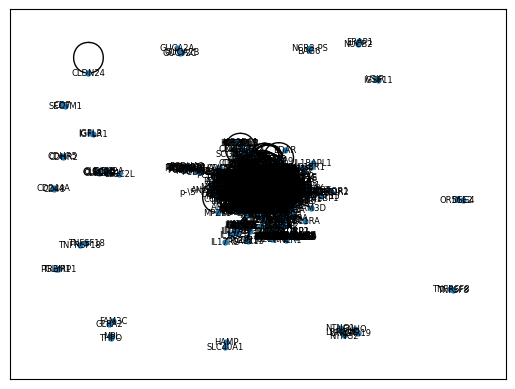

In [58]:
networkx.draw_networkx(G, node_size=12, font_size=6)

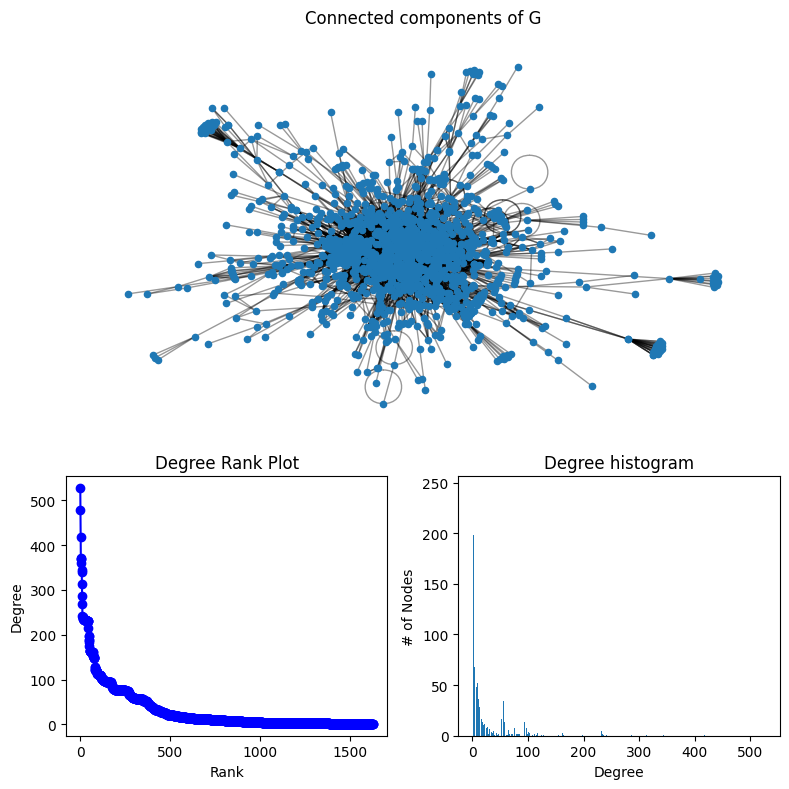

In [59]:
#Degree analysis
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(networkx.connected_components(G), key=len, reverse=True)[0])
pos = networkx.spring_layout(Gcc, seed=10396953)
networkx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
networkx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

# Embedding the KG

In [60]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

In [61]:
tf = TriplesFactory.from_labeled_triples(
        dKGlrp.to_numpy(dtype="str"),create_inverse_triples=False)
tf

TriplesFactory(num_entities=1630, num_relations=26, create_inverse_triples=False, num_triples=25823)

In [62]:
import json
with open(f"{data_dir}/dKGlrp_entityIDS.json","w") as outf:
    json.dump(tf.entity_id_to_label, outf)

In [68]:
import json
with open(f"{data_dir}/dKGlrp_relationIDS.json","w") as outf:
    json.dump(tf.relation_id_to_label, outf)

In [63]:
modelKGE = "KGlrp_50_unstratified_stopped_transe"

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [19143, 2582, 2583]
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /home/fc489/.data/pykeen/checkpoints/best-model-weights-172f0ed7-6926-471c-b662-17d933a21958.pt


Training epochs on cpu:   0%|          | 0/24 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 1.25s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.20557491289198607. Saved model weights to /home/fc489/.data/pykeen/checkpoints/best-model-weights-172f0ed7-6926-471c-b662-17d933a21958.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 1.24s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.5007742934572202. Saved model weights to /home/fc489/.data/pykeen/checkpoints/best-model-weights-172f0ed7-6926-471c-b662-17d933a21958.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/81 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/2.58k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.34s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=1630, num_relations=26, create_inverse_triples=False, num_triples=20658) to file:///gpfs/ysm/home/fc489/yaleCollab/KGEs/KGlrp_50_unstratified_stopped_transe/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///gpfs/ysm/home/fc489/yaleCollab/KGEs/KGlrp_50_unstratified_stopped_transe


TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(1630, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(26, 50)
    )
  )
  (weight_regularizers): ModuleList()
)
CPU times: user 2min 6s, sys: 6.66 s, total: 2min 12s
Wall time: 17.9 s


<AxesSubplot: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

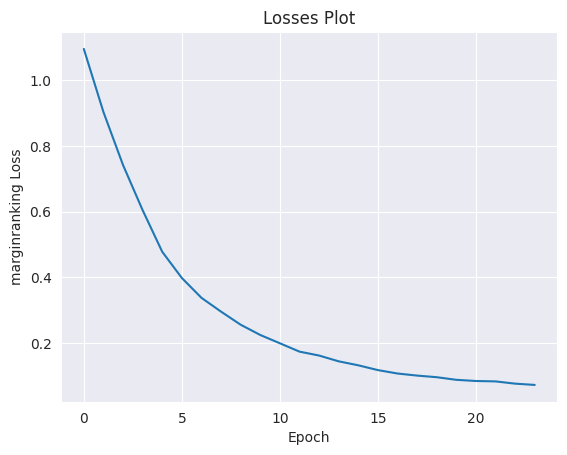

In [65]:
%%time

training, testing, validation = tf.split([.8, .1, .1])

result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model="TransE",
    model_kwargs=dict(embedding_dim=50),
    training_loop='sLCWA',
    negative_sampler='basic',
    stopper="early",
    random_seed=42,
    epochs=24,  # short epochs for testing - you should go
                # higher, especially with early stopper enabled
                
)

# result.save_to_directory(f"{kge_dir}/one50_unstratified_stopped_transe")
result.save_to_directory(f"{kge_dir}/{modelKGE}")

#model used TransE has only one representation for entities and relations, 
# so modules objects will be of length 1
print(result.model)
result.plot_losses()
# result.plot_early_stopping()

In [69]:
try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

print(trained_model)

TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(1630, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(26, 50)
    )
  )
  (weight_regularizers): ModuleList()
)


## Nodes

In [70]:
#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
import json
with open(f"{data_dir}/dKGlrp_entityIDS.json") as infile:
    entityIDS = json.load(infile)
dKGEnodes_50 = pd.DataFrame(entity_embeddings, index=entityIDS.values())
dKGEnodes_50

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
A2M,0.219666,-0.039182,-0.026662,0.085891,-0.119131,0.178660,0.238826,0.109184,-0.033884,-0.196837,...,-0.027558,0.031420,-0.144849,-0.130538,0.166265,-0.173349,-0.119897,0.099297,0.118321,0.056515
AANAT,0.254385,-0.158081,-0.252898,-0.190080,-0.070862,0.199925,-0.185834,0.087727,-0.084963,0.209219,...,-0.219202,0.031124,0.138489,-0.094840,-0.213139,-0.011053,0.003450,0.000344,-0.085192,0.049839
ABCA1,-0.148230,0.039298,-0.050733,-0.223077,0.048557,0.259075,0.175576,-0.077094,-0.137315,0.134887,...,0.175662,0.081355,0.173566,-0.040045,-0.041115,-0.067046,0.104487,-0.155728,-0.108752,0.201604
ABCA7,-0.004424,0.058882,0.023138,-0.098190,0.159816,0.148896,0.186814,-0.116938,0.125509,0.215010,...,-0.268176,0.052079,-0.258370,-0.146338,-0.267885,-0.043027,0.090031,-0.206991,-0.068150,-0.008894
ACKR1,-0.046418,0.125617,0.263907,0.036537,0.026962,0.030575,-0.055068,0.095953,0.194643,0.151734,...,0.072370,-0.111842,-0.240519,0.092630,0.118100,0.163409,0.182486,-0.270877,0.313851,0.102692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p-\S*Y705\S*-STAT3,-0.233802,-0.009267,-0.010101,-0.155420,-0.059539,0.170419,-0.264188,0.183177,-0.016836,-0.161282,...,0.025229,-0.150385,0.016503,0.152102,0.073242,0.239083,0.133376,0.011553,-0.000298,0.004091
p-\S+-MAPK(3|1)\s+,-0.117078,0.072058,-0.030490,-0.170077,-0.114498,0.190940,-0.265457,0.069402,0.006968,-0.195452,...,-0.240572,0.111877,0.155850,-0.193009,0.032061,0.142832,0.114328,-0.026216,-0.057229,-0.043368
p-\S+-RPS6\s+,0.035751,-0.160272,-0.246409,-0.148460,0.072921,-0.170288,0.193797,0.020317,0.217197,-0.154110,...,0.092083,0.003030,-0.061391,-0.025641,-0.136625,0.157763,0.000102,-0.019879,-0.141921,0.103505
p-\S+-SMAD(1|5|9),0.243996,-0.017542,-0.021499,-0.186936,-0.074597,-0.064648,-0.212029,0.102044,0.140596,-0.049357,...,0.055059,-0.092415,0.042087,-0.125646,-0.012093,-0.109508,0.155502,0.078110,0.126772,0.019472


In [148]:
# %%time
# dRPTMpath = pd.DataFrame(columns=["head","relation","tail"])
# for p in PTMdict.values():
#     for r in dLR["tail"].unique():
#         for name, group in mdPathPE:
#             if any(group[2].str.contains(r)):
#                 if any(group[2].str.contains(p)):
#                     row = pd.Series({"head":r, "relation":name, "tail":p})
#                     dRPTMpath = pd.concat([dRPTMpath, row.to_frame().T])
# dRPTMpath = dRPTMpath.dropna().drop_duplicates().reset_index(drop=True)

newpd = pd.DataFrame(columns=["entity","pathway"])
for i in entityIDS.values():
    if any(mdPathPE.obj[2].str.contains(i)):
        for n in mdPathPE.obj.loc[mdPathPE.obj[2].str.contains(i)][5].unique():
            row = pd.Series({"entity":i, "pathway":n})
            newpd = pd.concat([newpd, row.to_frame().T])
    
newpd

/tmp/ipykernel_14847/3343905297.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if any(mdPathPE.obj[2].str.contains(i)):
/tmp/ipykernel_14847/3343905297.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  for n in mdPathPE.obj.loc[mdPathPE.obj[2].str.contains(i)][5].unique():


,entity,pathway
0,ABCA1,Signaling by Nuclear Receptors
0,ACKR2,Signaling by GPCR
0,ACVR1,Signaling by TGFB family members
0,ACVR1B,Signaling by TGFB family members
0,ACVR1C,Signaling by TGFB family members
...,...,...
0,p-\S+-MAPK(3|1)\s+,"Signaling by Rho GTPases, Miro GTPases and RHO..."
0,p-\S+-RPS6\s+,MTOR signalling
0,p-\S+-SMAD(1|5|9),Signaling by TGFB family members
0,p-\S+-SMAD(2|3),Signaling by NOTCH


In [153]:
newpd["pathway"].describe()

count                  1405
unique                   34
top       Signaling by GPCR
freq                    439
Name: pathway, dtype: object

### DR on KGE

In [78]:
from sklearn.decomposition import PCA

dKGEn_pca = PCA(n_components=2).fit_transform(dKGEnodes_50)
dKGEn_pca = pd.DataFrame(dKGEn_pca, index=entityIDS.values())

<AxesSubplot: title={'center': 'Nodes'}, xlabel='PC-1', ylabel='PC-2'>

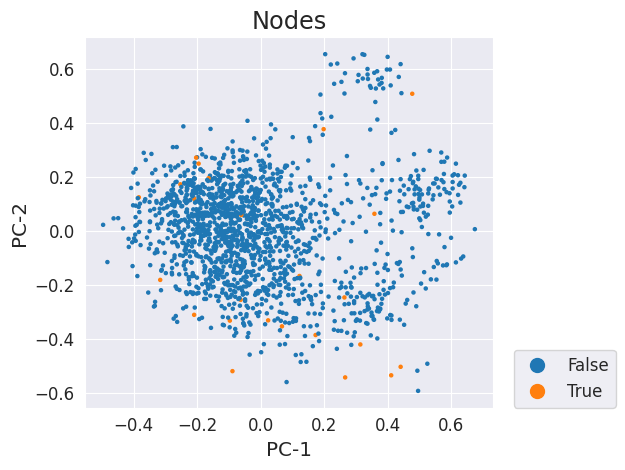

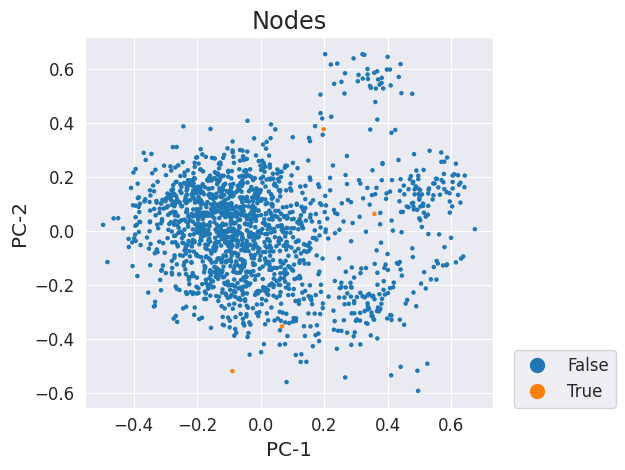

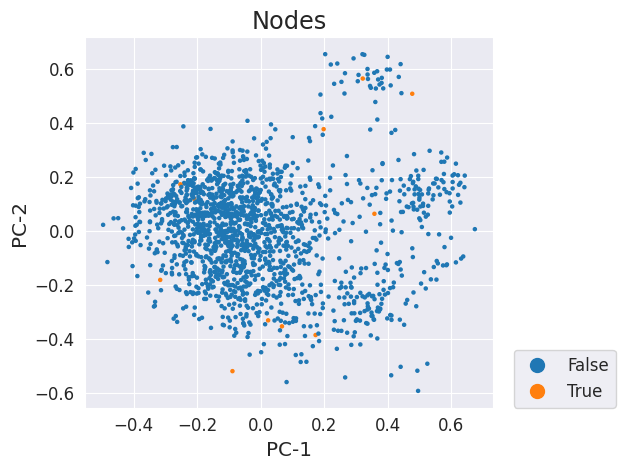

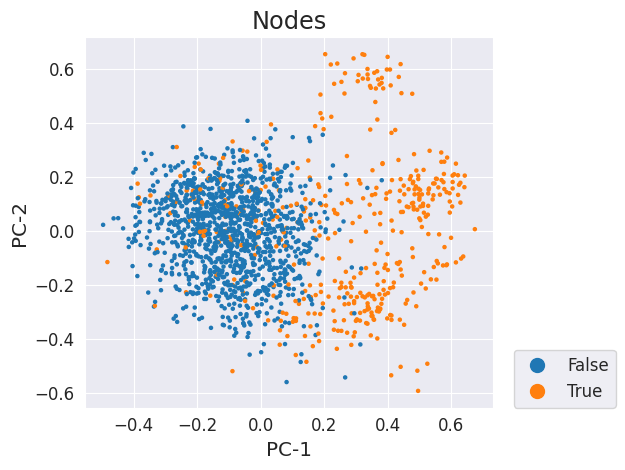

In [154]:
scprep.plot.scatter2d(dKGEn_pca,
    c=dKGEn_pca.index.isin(newpd.loc[newpd["pathway"]=="Cell Cycle, Mitotic","entity"]),
    title="Nodes", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_pca,
    c=dKGEn_pca.index.isin(newpd.loc[newpd["pathway"]=="Meiosis","entity"]),
    title="Nodes", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_pca,
    c=dKGEn_pca.index.isin(newpd.loc[newpd["pathway"]=="Chromosome Maintenance","entity"]),
    title="Nodes", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_pca,
    c=dKGEn_pca.index.isin(newpd.loc[newpd["pathway"]=="Signaling by GPCR","entity"]),
    title="Nodes", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

In [80]:
dKGEn_phate = phate.PHATE().fit_transform(dKGEnodes_50)
dKGEn_phate = pd.DataFrame(dKGEn_phate, index=entityIDS.values())

Calculating PHATE...
  Running PHATE on 1630 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.17 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.19 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 0.71 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.28 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.70 seconds.
Calculated PHATE in 3.88 seconds.


<AxesSubplot: title={'center': 'Nodes'}, xlabel='PHATE-1', ylabel='PHATE-2'>

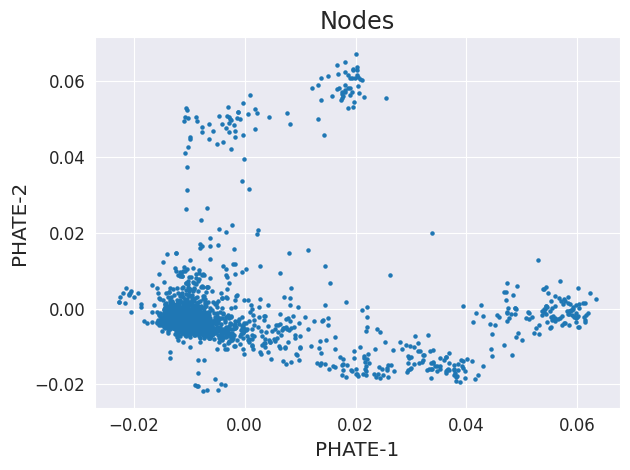

In [133]:
scprep.plot.scatter2d(dKGEn_phate, 
    title="Nodes", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

## Edges
Will need to use the top level pathways from REACTOME as way of annotating the edges to see if there's any kind of logical ordering to it

In [73]:
#Construct edges dataframe
relation_embeddings = trained_model.relation_representations[0](indices=None).detach().cpu().numpy()
import json
with open(f"{data_dir}/dKGlrp_relationIDS.json") as infile:
    relationIDS = json.load(infile)
dKGEedges_50 = pd.DataFrame(relation_embeddings, index=relationIDS.values())
dKGEedges_50

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Apoptosis,-0.157899,-0.154146,-0.298445,-0.095809,0.150770,-0.015894,-0.136421,0.224431,-0.242968,0.104206,...,0.037375,0.118270,-0.057894,-0.238254,0.099322,0.217924,-0.080489,-0.091356,0.286288,0.076063
"Cell Cycle, Mitotic",-0.125293,-0.263688,0.123621,-0.258040,-0.009149,0.165112,-0.115261,0.091220,-0.220511,-0.267279,...,-0.157680,0.263529,0.045180,0.092892,-0.222209,-0.108372,-0.054511,-0.032742,0.055648,0.199805
Cell junction organization,-0.025067,0.141306,-0.127374,0.122957,-0.254559,-0.029740,0.233324,0.212411,-0.001212,0.288198,...,0.182700,0.034637,-0.043209,-0.203699,-0.075677,-0.181722,0.174380,-0.312992,0.044250,0.181161
Cellular responses to stress,-0.222393,-0.154182,0.239340,-0.321125,0.196903,0.265012,-0.005785,0.015269,-0.116495,-0.289980,...,-0.012950,0.172568,-0.107870,-0.091065,0.138135,0.241993,0.156047,0.088271,0.029265,-0.179692
Chromosome Maintenance,0.039575,-0.272700,0.018017,0.175536,-0.249297,-0.091759,-0.165360,0.074887,-0.245165,0.186442,...,-0.062196,-0.307471,-0.054533,0.214261,-0.000790,-0.108631,0.142585,0.069957,0.322248,0.182480
Death Receptor Signalling,0.076787,-0.239637,-0.158404,-0.080104,0.090262,0.239605,0.140906,-0.180575,-0.051538,0.138311,...,-0.136056,-0.106414,-0.042036,0.040412,0.129530,-0.014696,0.123596,-0.176830,-0.071241,0.119616
Integrin signaling,-0.066130,0.131637,0.222493,0.173051,-0.101419,-0.125992,0.136950,0.075666,-0.014812,0.273214,...,0.125047,0.181960,-0.044456,-0.019136,0.176534,-0.099254,0.037347,0.209910,-0.001362,-0.026315
Intracellular signaling by second messengers,0.126043,-0.344834,-0.094950,0.248133,-0.226891,0.276168,0.225196,0.158353,0.277077,-0.215515,...,0.016686,0.171167,-0.010244,-0.348628,-0.062856,-0.016804,-0.102376,-0.140016,0.243451,-0.292579
LR,0.032450,0.271794,0.001381,-0.175340,0.385999,0.076081,-0.128946,0.308464,0.134531,-0.196180,...,-0.285813,0.148445,-0.044960,0.093891,0.023275,0.198637,0.174625,-0.236975,0.339585,-0.164982
MAPK family signaling cascades,0.047349,0.157310,0.021369,0.249602,-0.258033,-0.076463,-0.253829,0.346175,0.048189,0.188979,...,-0.276533,0.157680,-0.010664,-0.335181,0.247700,0.033908,-0.033168,-0.134626,-0.085994,0.159127


In [113]:
#Metadata
dftest = pd.read_csv(f"{data_dir}/DBs/ReactomePathwaysRelation.txt", sep="\t", header=None)
dftest = dftest.loc[dftest[0].isin([
                "R-HSA-162582",#Signal transduction
                "R-HSA-5357801",#Programmed cell death
                "R-HSA-73894",#DNA repair
                "R-HSA-8953897",#Cell response to stress
                "R-HSA-1500931",#Cell-cell commns
                "R-HSA-1640170"#Cell cycle
                                                    ])].drop_duplicates()
dftest.head()

,0,1
10846,R-HSA-1500931,R-HSA-373753
10847,R-HSA-1500931,R-HSA-391160
10848,R-HSA-1500931,R-HSA-446728
10896,R-HSA-162582,R-HSA-157118
10897,R-HSA-162582,R-HSA-165159


In [114]:
PathDict = pd.read_csv(f"{data_dir}/DBs/ReactomePathways.txt", sep="\t", header=None)
PathDict = PathDict.loc[PathDict[2]=="Homo sapiens",[0,1]].drop_duplicates()
PathDict = PathDict.set_index([0]).to_dict()[1]

In [115]:
dftest = dftest.replace(PathDict).set_index([1])
dftest

,0
1,
Nephrin family interactions,Cell-Cell communication
Signal regulatory protein family interactions,Cell-Cell communication
Cell junction organization,Cell-Cell communication
Signaling by NOTCH,Signal Transduction
MTOR signalling,Signal Transduction
Signaling by WNT,Signal Transduction
Signaling by Hippo,Signal Transduction
Signaling by Leptin,Signal Transduction
Integrin signaling,Signal Transduction


In [118]:
dftest = dftest.loc[dftest.index.isin(dKGEe_pca.index)]
dftest

,0
1,
Nephrin family interactions,Cell-Cell communication
Cell junction organization,Cell-Cell communication
Signaling by NOTCH,Signal Transduction
MTOR signalling,Signal Transduction
Signaling by WNT,Signal Transduction
Signaling by Hippo,Signal Transduction
Signaling by Leptin,Signal Transduction
Integrin signaling,Signal Transduction
Signaling by GPCR,Signal Transduction


In [124]:
dftest = dftest.reindex(index=dKGEe_pca.index).fillna(value="LR")
dftest

,0
Apoptosis,Programmed Cell Death
"Cell Cycle, Mitotic",Cell Cycle
Cell junction organization,Cell-Cell communication
Cellular responses to stress,Cellular responses to stimuli
Chromosome Maintenance,Cell Cycle
Death Receptor Signalling,Signal Transduction
Integrin signaling,Signal Transduction
Intracellular signaling by second messengers,Signal Transduction
LR,LR
MAPK family signaling cascades,Signal Transduction


### DR on KGE

In [82]:
from sklearn.decomposition import PCA

dKGEe_pca = PCA(n_components=2).fit_transform(dKGEedges_50)
dKGEe_pca = pd.DataFrame(dKGEe_pca, index=relationIDS.values())

/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


<AxesSubplot: title={'center': 'Edges'}, xlabel='PC-1', ylabel='PC-2'>

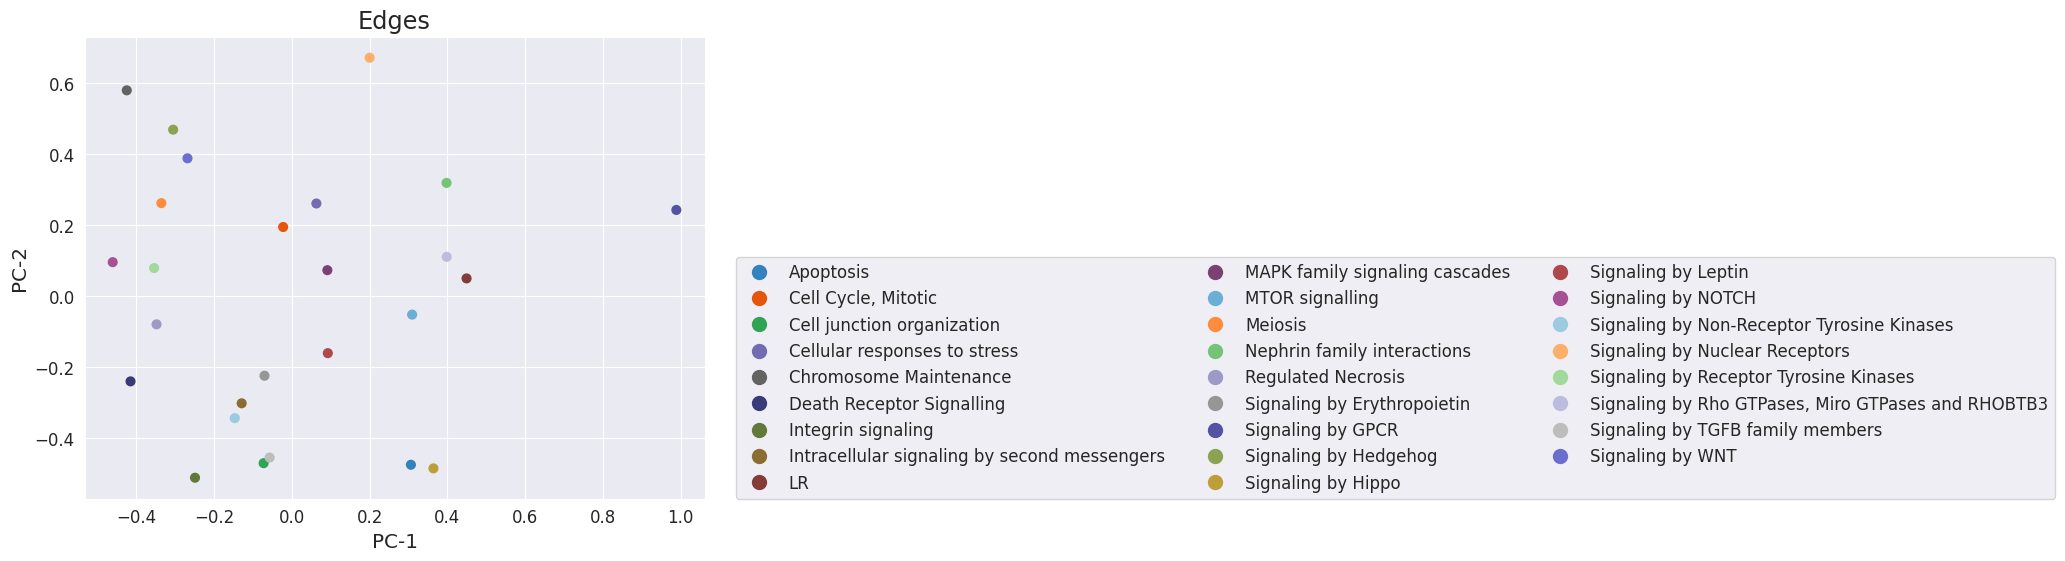

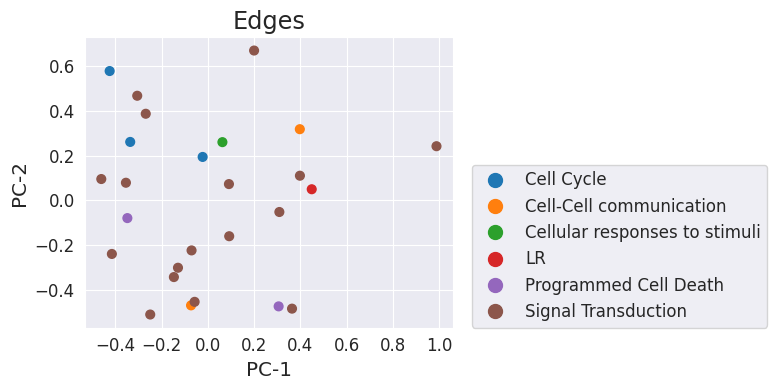

In [134]:
scprep.plot.scatter2d(dKGEe_pca,
    c=dKGEe_pca.index,
    title="Edges", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8, 6),dpi=480)
scprep.plot.scatter2d(dKGEe_pca,
    c=dftest[0],
    title="Edges", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8, 4),dpi=480)

In [85]:
dKGEe_phate = phate.PHATE().fit_transform(dKGEedges_50)
dKGEe_phate = pd.DataFrame(dKGEe_phate, index=relationIDS.values())

Calculating PHATE...
  Running PHATE on 26 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 10
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


<AxesSubplot: title={'center': 'Edges'}, xlabel='PHATE-1', ylabel='PHATE-2'>

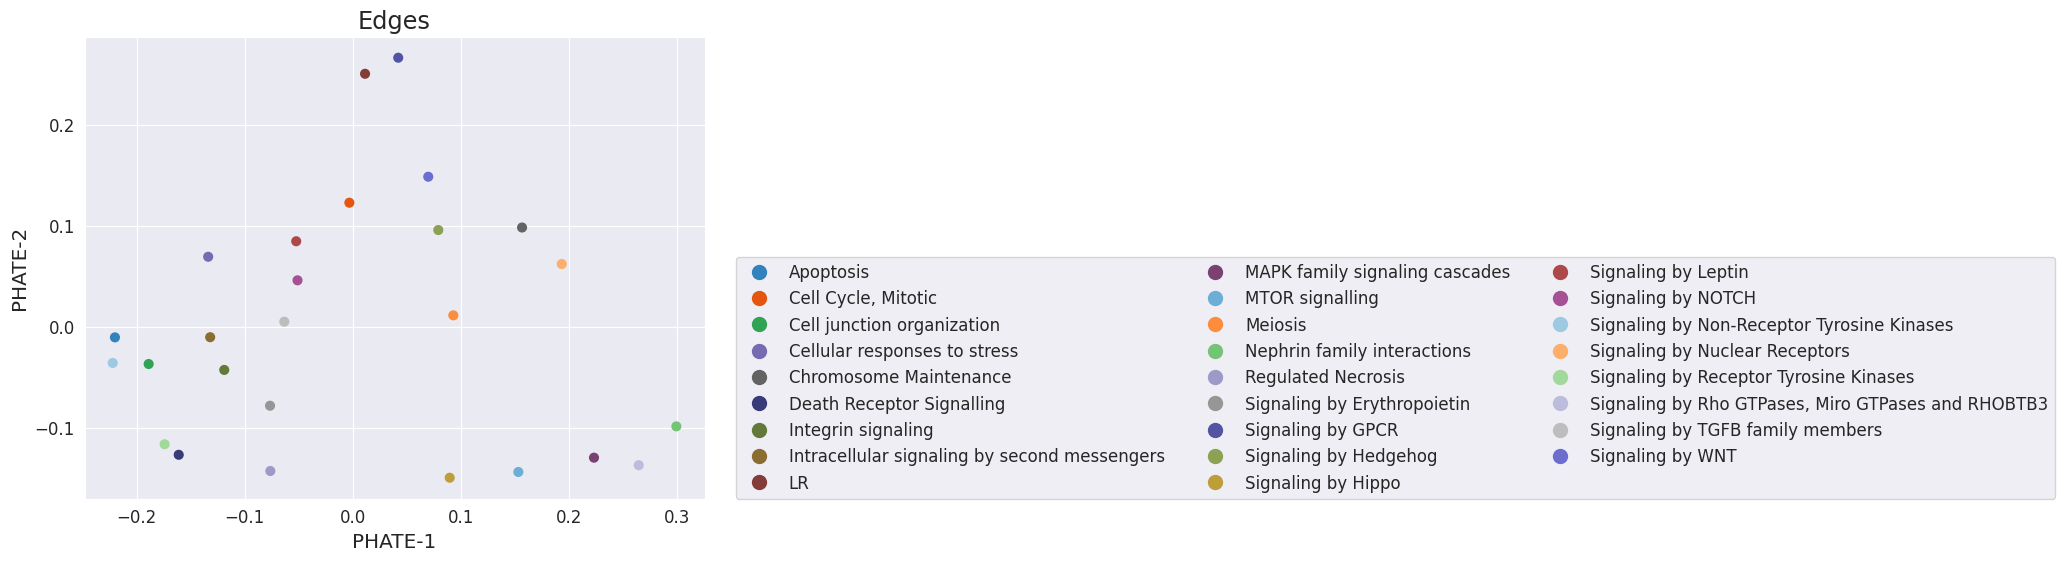

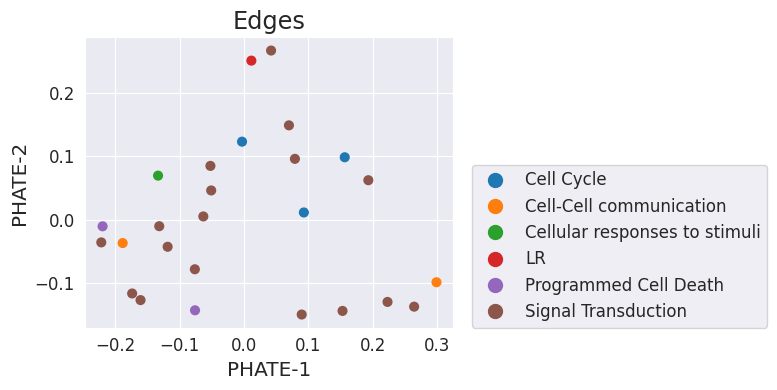

In [135]:
scprep.plot.scatter2d(dKGEe_phate,
    c=dKGEe_phate.index,
    title="Edges", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8, 6),dpi=480)
scprep.plot.scatter2d(dKGEe_phate,
    c=dftest[0],
    title="Edges", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8, 4),dpi=480)